# Stochastic Volatility using pymc3
Summary and learnings from reading the links in the refrences

From Hoffman & Gelman(2011) we get`the following generative process
$$\tau \sim exp(100)$$
$$\nu \sim exp(100)$$
$$s_1 \sim exp(100)$$
$$log(s_i) \sim N(log(s_{i-1}) , \tau^{-1})$$
$$\frac{log(y_i) - log(y_{i-1})}{s_i} \sim t_{\nu}$$

- $\tau$ is the precision (like the standard deviation of $s_i$) I think
- $s_i$ refers to scale parameter


In the pymc3 example, we have see some slightly different descriptions

$$\sigma \sim exp(50)$$
$$\nu \sim exp(0.1)$$
$$s_i \sim N((s_{i-1}) , \sigma^{2})$$
$${log(y_i) - log(y_{i-1})} \sim t(\nu , 0 , exp(-2s_i))$$

- Here, s_1 is not defined so clearly but its ok
- I think $\tau$ and $\sigma$ symbols are switched but it's ok
- s_i as the log volatility process is transformed into a volatility process
- It uses precision $\frac{1}{\sigma^{2}}$to parameterize instead of sigma



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

np.random.seed(0)

# 1. Loading Data (Daily Log Returns)

In [2]:
returns = pd.read_csv(pm.get_data("SP500.csv"), index_col='Date')
returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()
returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


# 2. Visualizing "volatility cluters"

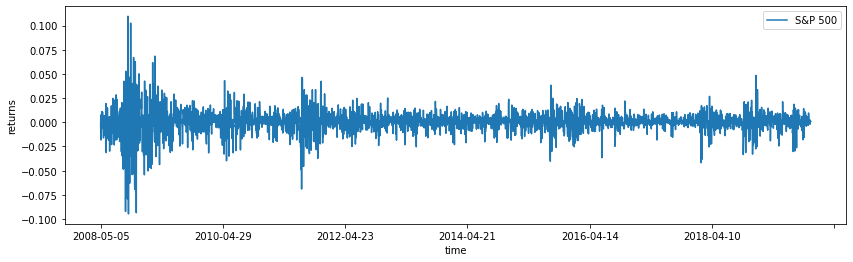

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label='S&P 500', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

# 3. Create the model

### pymc3 documentation model
Recall

$$\sigma \sim exp(50)$$
$$\nu \sim exp(0.1)$$
$$s_i \sim N((s_{i-1}) , \sigma^{2})$$
$${log(y_i) - log(y_{i-1})} \sim t(\nu , 0 , exp(-2s_i))$$

### Model from pymc3 (copied with no amendments)

In [4]:
def make_stochastic_volatility_model(data):
    with pm.Model() as model:
        step_size = pm.Exponential('step_size', 10)
        volatility = pm.GaussianRandomWalk('volatility', sigma=step_size, shape=len(data))
        nu = pm.Exponential('nu', 0.1)
        returns = pm.StudentT('returns',
                        nu=nu,
                        lam=np.exp(-2*volatility),
                        observed=data["change"])
    return model

sv_1 = make_stochastic_volatility_model(returns)

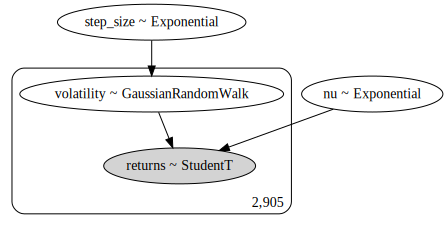

In [5]:
pm.model_to_graphviz(sv_1)

### Original Model from paper
### Maybe let's just use the original model's notation and convention etc
$$\tau \sim exp(100)$$
$$\nu \sim exp(100)$$
$$log(s_i) \sim N(log(s_{i-1}) , \tau^{-1})$$
$$\frac{log(y_i) - log(y_{i-1})}{s_i} \sim t_{\nu}$$
$$Adding\;an\;additional\;line\;for\;stupid\;people\;like\;myself$$

$${log(y_i) - log(y_{i-1})} \sim t_{\nu},\;\mu = 0 , \sigma = s_i$$

$$However\;since\;here,\;t\;is\;parameterize\;by\;precision\;\frac{1}{\sigma^2}$$

$${log(y_i) - log(y_{i-1})} \sim t(\nu , 0 , \frac{1}{s_i^{2}})$$


In [6]:
def original_model(data):
    with pm.Model() as model:
        
        # exponential in pymc3 is parameterize by inverse of mean
        tau = pm.Exponential('tau', 1/100)
        nu = pm.Exponential('nu', 1/100)
        
        ## changed to log_s make notation clearer
        ## changed to 1/tau previously is sigma
        log_s = pm.GaussianRandomWalk('log_s', sigma = 1/tau, shape=len(data))
        
        # Need to transform log_s
        # s = np.exp(log_s)
        # lambda = s ** (-2)
        # Hence, lambda = np.exp(log_s) ** -2 = np.exp(-2*log_s)
        volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*log_s))
        returns = pm.StudentT('returns', 
                        nu = nu, 
                        lam = volatility_process,
                        observed=data["change"])
    return model

om = original_model(returns)


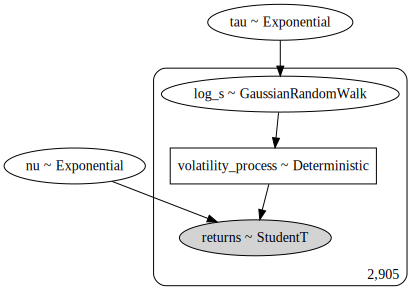

In [7]:
pm.model_to_graphviz(om)

# 4. Visualize the prior

In [8]:
with sv_1:
    prior = pm.sample_prior_predictive(500)

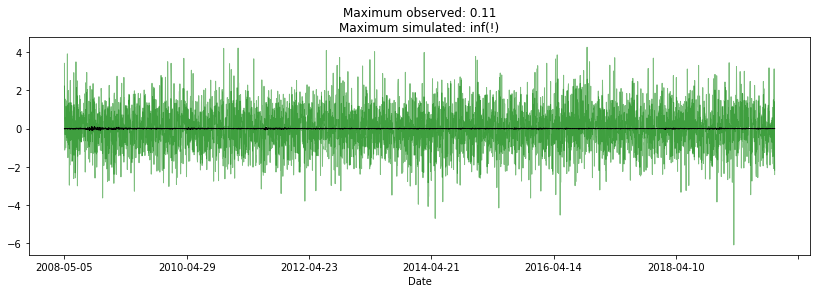

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))
returns['change'].plot(ax=ax, lw=1, color='black')
ax.plot(prior['returns'][4:6].T, 'g', alpha=0.5, lw=1, zorder=-10)

max_observed, max_simulated = np.max(np.abs(returns['change'])), np.max(np.abs(prior['returns']))
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

We plot and inspect the prior predictive. This is many orders of magnitude larger than the actual returns we observed. This may suggest changing our priors: a return that our model considers plausible would violate all sorts of constraints by a huge margin: the total value of all goods and services the world produces is ~$\$10^9$, so we might reasonably not expect any returns above that magnitude.
`
That said, we get somewhat reasonable results fitting this model anyways, and it is standard, so we leave it as is.

# 5. Fit and check Model

### pymc3 Model

In [10]:
with sv_1:
    trace_1 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, volatility, step_size]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [10:44<00:00, 12.42draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


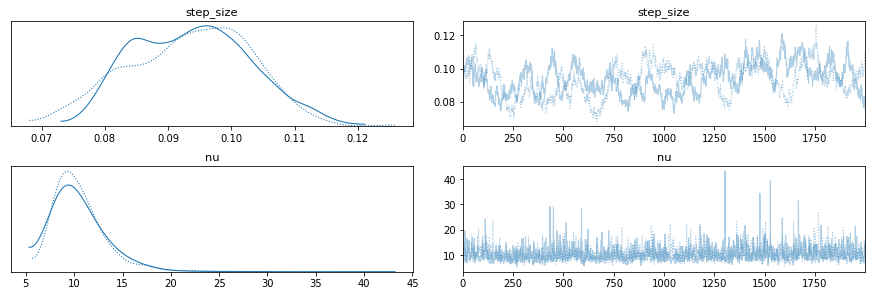

In [11]:
pm.traceplot(trace_1, var_names=['step_size', 'nu']);

### original model

In [12]:
with om:
    trace_om = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_s, nu, tau]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [11:43<00:00, 11.38draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


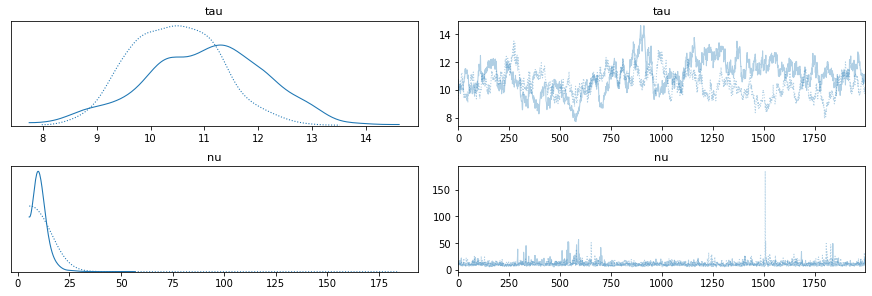

In [13]:
pm.traceplot(trace_om, var_names=['tau', 'nu']);

# Perform Posterior Predictive Checks
This function will randomly draw X samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from the distribution specified in trace

### pymc3 model

In [14]:
with sv_1:
    posterior_predictive_1 = pm.sample_posterior_predictive(trace_1)

100%|██████████| 4000/4000 [00:09<00:00, 444.23it/s]


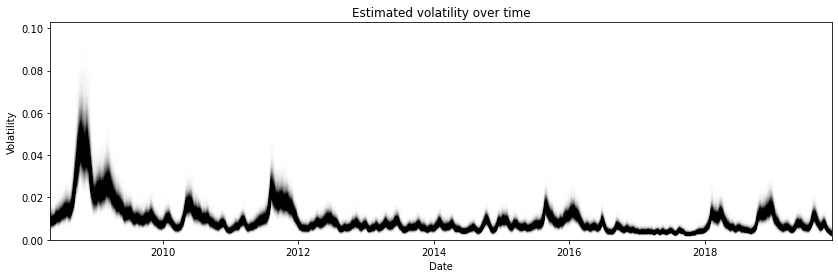

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = np.exp(trace_1['volatility'])[::5].T
x_vals = np.vstack([returns.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Estimated volatility over time', xlabel='Date', ylabel='Volatility');

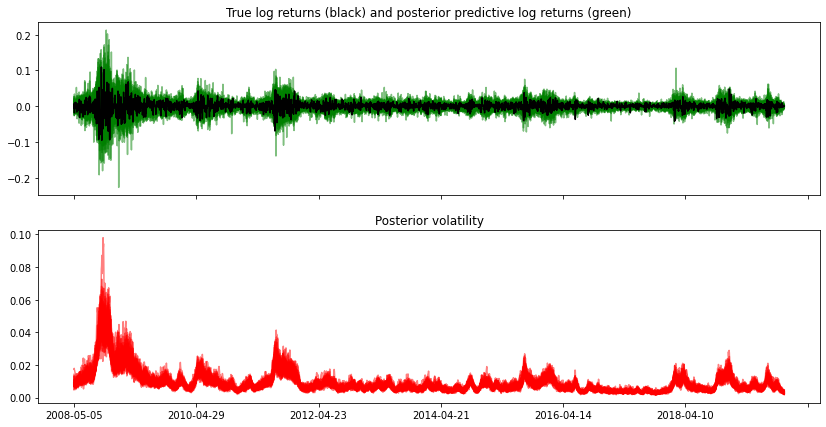

In [16]:

fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns['change'].plot(ax=axes[0], color='black')

axes[0].plot(posterior_predictive_1['returns'][::100].T, 'g', alpha=0.5, zorder=-10)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")

axes[1].plot(np.exp(trace_1['volatility'][::100].T), 'r', alpha=0.5)
axes[1].set_title("Posterior volatility");

### original model

In [17]:
with om:
    posterior_predictive_om = pm.sample_posterior_predictive(trace_om)

100%|██████████| 4000/4000 [00:12<00:00, 321.18it/s]


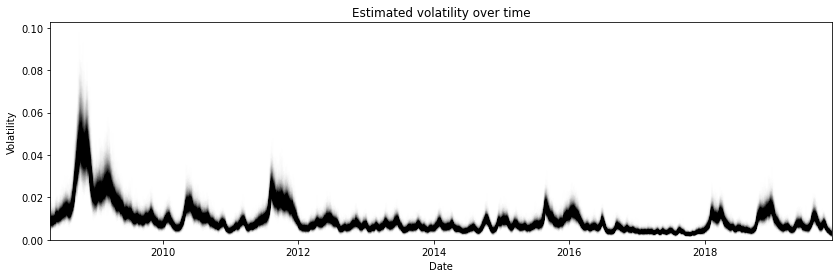

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = np.exp(trace_om['log_s'])[::5].T
x_vals = np.vstack([returns.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Estimated volatility over time', xlabel='Date', ylabel='Volatility');

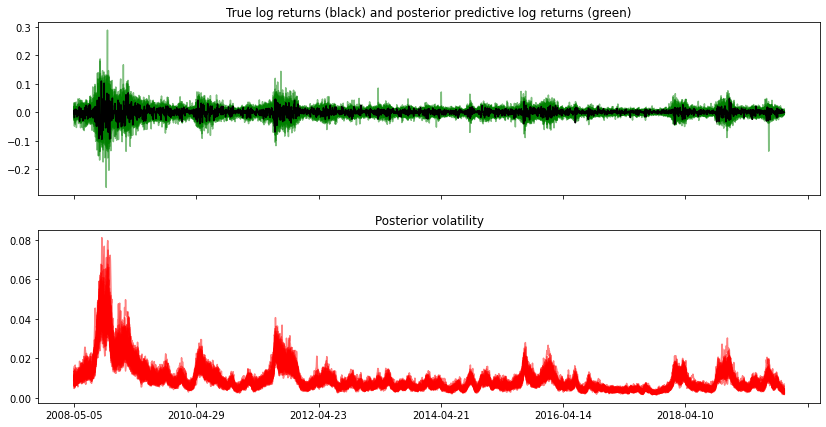

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns['change'].plot(ax=axes[0], color='black')

axes[0].plot(posterior_predictive_om['returns'][::100].T, 'g', alpha=0.5, zorder=-10)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")

axes[1].plot(np.exp(trace_om['log_s'][::100].T), 'r', alpha=0.5)
axes[1].set_title("Posterior volatility");

## References

pymc3 has 4 notebooks that discusses the model

1. https://docs.pymc.io/notebooks/stochastic_volatility.html
2. https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/stochastic_volatility.ipynb
3. https://docs.pymc.io/notebooks/getting_started.html#Case-study-1:-Stochastic-volatility
4. https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/stochastic_volatility.html

## Original Paper
http://arxiv.org/abs/1111.4246

In [24]:
# import arviz as az
# az.summary(trace_om)

In [27]:
with om:
    test = pm.sample_posterior_predictive(trace_om , samples = 10)
# test["returns"].shape

100%|██████████| 10/10 [00:00<00:00, 140.38it/s]


(10, 2905)